<a href="https://colab.research.google.com/github/suparuek2405/Stock-screening-with-python/blob/main/Group_assignment_Tacocat_set_yfinance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install libraries
# !pip install pandas
# !pip install numpy
# !pip install yfinance

In [1]:
#import library
import yfinance as yf
import pandas as pd
import numpy as np
from google.colab import drive
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300  # Set the default DPI to 300
from matplotlib.ticker import FuncFormatter
warnings.filterwarnings("ignore", category=RuntimeWarning)

### This part is for retrive data, skip if already got data.

In [2]:
#Function for get data from yfinance
def rename_columns_to_year_end(df):
    df_rt = df.copy()
    years = df_rt.columns.year
    year_end_dates = [pd.Timestamp(f"{year}-12-31") for year in years]
    df_rt.columns = year_end_dates
    return df_rt

def get_balance_sheet(ticker):
  balance_sheet_df = pd.DataFrame()
  n = len(ticker)
  print("start getting balance sheet")
  for c,i in enumerate(ticker):
    #retrive data from yfinance
    stock = yf.Ticker(i)
    raw = stock.balancesheet

    #rename column
    bs = rename_columns_to_year_end(raw)

      #reset index and rename it
    bs.reset_index(inplace=True)
    bs.rename(columns={'index': 'data'}, inplace=True)
    bs['symbol'] = i.split('.')[0]

    # Check for duplicates in the 'data' column and drop them
    bs = bs[~bs.duplicated(subset=['data'])]
    bs.set_index(['symbol', 'data'], inplace=True)

    #change type data of column for better look
    bs.columns = pd.to_datetime(bs.columns)

    #append to dataframe
    balance_sheet_df = pd.concat([balance_sheet_df, bs])
    print(f"{c+1}/{n} {i}")
  print("finish getting balance sheet")
  return balance_sheet_df

def get_income_statement(ticker):
  income_statement_df = pd.DataFrame()
  n = len(ticker)
  print("start getting income statement")
  for c,i in enumerate(ticker):
    #retrive data from yfinance
    stock = yf.Ticker(i)
    raw = stock.financials

    #rename column
    is_df = rename_columns_to_year_end(raw)

    #reset index and rename it
    is_df.reset_index(inplace=True)
    is_df.rename(columns={'index': 'data'}, inplace=True)
    is_df['symbol'] = i.split('.')[0]

    # Check for duplicates in the 'data' column and drop them
    is_df = is_df[~is_df.duplicated(subset=['data'])]
    is_df.set_index(['symbol', 'data'], inplace=True)

    #change type data of column for better look
    is_df.columns = pd.to_datetime(is_df.columns)

    #append to dataframe
    income_statement_df = pd.concat([income_statement_df, is_df])
    print(f"{c+1}/{n} {i}")
  print("finish getting income statement")
  return income_statement_df

def get_cashflow_statement(ticker):
  cashflow_statement_df = pd.DataFrame()
  n = len(ticker)
  print("start getting cashflow statement")
  for c,i in enumerate(ticker):
    #retrive data from yfinance
    stock = yf.Ticker(i)
    raw = stock.cashflow

    #rename column
    cf_df = rename_columns_to_year_end(raw)

    #reset index and rename it
    cf_df.reset_index(inplace=True)
    cf_df.rename(columns={'index': 'data'}, inplace=True)
    cf_df['symbol'] = i.split('.')[0]

    # Check for duplicates in the 'data' column and drop them
    cf_df = cf_df[~cf_df.duplicated(subset=['data'])]
    cf_df.set_index(['symbol', 'data'], inplace=True)

    #change type data of column for better look
    cf_df.columns = pd.to_datetime(cf_df.columns)

    #append to dataframe
    cashflow_statement_df = pd.concat([cashflow_statement_df, cf_df])
    print(f"{c+1}/{n} {i}")
  print("finish getting cashflow statement")
  return cashflow_statement_df

def get_monthly_stock_prices(ticker,start_date = "2022-01-01", end_date="2024-09-30"):
  stock = yf.Ticker(ticker)
  data = stock.history(start=start_date, end=end_date, interval="1mo")
  data = data.set_index(pd.to_datetime(data.index))

  # Resample to the start of each month
  monthly_prices = data['Close'].resample('MS').first()
  monthly_prices = pd.DataFrame(monthly_prices)
  monthly_prices['symbol'] = ticker.split('.')[0]
  monthly_prices.index = monthly_prices.index.to_period('M').to_timestamp(how='start')
  return monthly_prices

def get_dividend_data(ticker, start_date="2022-01-01", end_date="2024-09-30"):
  stock = yf.Ticker(ticker)
  dividends = stock.dividends
  # Filter dividends based on the specified date range
  dividends = dividends[(dividends.index >= start_date) & (dividends.index <= end_date)]
  if not dividends.empty:
    dividends_df = pd.DataFrame(dividends)
    dividends_df['symbol'] = ticker.split('.')[0]
    dividends_df = dividends_df.rename(columns={'Dividends':'amount'})
    dividends_df.index = dividends_df.index.to_period('M').to_timestamp(how='start')
    return dividends_df

def get_financial_data(ticker):
  balance_sheet = get_balance_sheet(ticker)
  income_statement = get_income_statement(ticker)
  cashflow_statement = get_cashflow_statement(ticker)
  return balance_sheet, income_statement, cashflow_statement

In [20]:
#df = pd.read_csv('/content/drive/My Drive/Tools/Group Assignment/set_scraped.csv')
df = pd.read_csv('https://raw.githubusercontent.com/suparuek2405/Stock-screening-with-python/main/set_scraped.csv')

In [21]:
bkk = df.copy()
bkk = bkk[['symbol', 'text-start', 'text-start 2', 'symbol 2', 'symbol 3']]
bkk.columns = ['symbol', 'company_name', 'market', 'industry', 'sector']
bkk['ticker'] = bkk['symbol'] + '.BK'
bkk.head(10)

,symbol,company_name,market,industry,sector,ticker
0,24CS,บริษัท ทเวนตี้ โฟร์ คอน แอนด์ ซัพพลาย จำกัด (ม...,mai,PROPCON,NaN,24CS.BK
1,2S,บริษัท 2 เอส เมทัล จำกัด (มหาชน),SET,INDUS,STEEL,2S.BK
2,3K-BAT,บริษัท ไทย เอ็นเนอร์จี สโตเรจ เทคโนโลยี จำกัด ...,SET,INDUS,AUTO,3K-BAT.BK
3,A,บริษัท อารียา พรอพเพอร์ตี้ จำกัด (มหาชน),SET,PROPCON,PROP,A.BK
4,A5,บริษัท แอสเซท ไฟว์ กรุ๊ป จำกัด (มหาชน),mai,PROPCON,NaN,A5.BK
5,AAI,บริษัท เอเชี่ยน อะไลอันซ์ อินเตอร์เนชั่นแนล จำ...,SET,AGRO,FOOD,AAI.BK
6,AAV,บริษัท เอเชีย เอวิเอชั่น จำกัด (มหาชน),SET,SERVICE,TRANS,AAV.BK
7,ABM,บริษัท เอเชีย ไบโอแมส จำกัด (มหาชน),mai,RESOURC,NaN,ABM.BK
8,ACAP,บริษัท เอเชีย แคปปิตอล กรุ๊ป จำกัด (มหาชน),mai,FINCIAL,NaN,ACAP.BK
9,ACC,บริษัท แอดวานซ์ คอนเนคชั่น คอร์ปอเรชั่น จำกัด ...,SET,RESOURC,ENERG,ACC.BK


In [22]:
set_list = bkk['ticker']
ticker_error = ['DIMET.BK'] #exclude error ticker
set_list = set_list[set_list.isin(ticker_error) == False]

In [ ]:
#run this code to start retrive data from yfinance
bl_st, ic_st, cf_st = get_financial_data(set_list)

In [24]:
# run this code below to download file
# bl_st.to_csv('balance_sheet.csv')
# ic_st.to_csv('income_statement.csv')
# cf_st.to_csv('cashflow_statement.csv')

# from google.colab import files
# files.download('balance_sheet.csv')
# files.download('income_statement.csv')
# files.download('cashflow_statement.csv')

------

## After get data


In [3]:
#do not change variable name due to function using these as global variable
df = pd.read_csv('https://raw.githubusercontent.com/suparuek2405/Stock-screening-with-python/main/set_scraped.csv')
bkk = df.copy()
bkk = bkk[['symbol', 'text-start', 'text-start 2', 'symbol 2', 'symbol 3']]
bkk.columns = ['symbol', 'company_name', 'market', 'industry', 'sector']
bkk['ticker'] = bkk['symbol'] + '.BK'
bl = pd.read_csv('https://raw.githubusercontent.com/suparuek2405/Stock-screening-with-python/refs/heads/main/balance_sheet.csv')
ic = pd.read_csv('https://raw.githubusercontent.com/suparuek2405/Stock-screening-with-python/refs/heads/main/income_statement.csv')
cf = pd.read_csv('https://raw.githubusercontent.com/suparuek2405/Stock-screening-with-python/refs/heads/main/cashflow_statement.csv')

In [4]:
bl.data.unique()

array(['Treasury Shares Number', 'Ordinary Shares Number', 'Share Issued',
       'Net Debt', 'Total Debt', 'Tangible Book Value',
       'Invested Capital', 'Working Capital', 'Net Tangible Assets',
       'Capital Lease Obligations', 'Common Stock Equity',
       'Total Capitalization', 'Total Equity Gross Minority Interest',
       'Stockholders Equity', 'Other Equity Interest',
       'Gains Losses Not Affecting Retained Earnings',
       'Other Equity Adjustments', 'Retained Earnings',
       'Additional Paid In Capital', 'Capital Stock', 'Common Stock',
       'Total Liabilities Net Minority Interest',
       'Total Non Current Liabilities Net Minority Interest',
       'Other Non Current Liabilities', 'Employee Benefits',
       'Non Current Pension And Other Postretirement Benefit Plans',
       'Long Term Debt And Capital Lease Obligation',
       'Long Term Capital Lease Obligation', 'Long Term Debt',
       'Current Liabilities', 'Other Current Liabilities',
       'Current 

In [8]:
ic.data.unique()

array(['Tax Effect Of Unusual Items', 'Tax Rate For Calcs',
       'Normalized EBITDA', 'Total Unusual Items',
       'Total Unusual Items Excluding Goodwill',
       'Net Income From Continuing Operation Net Minority Interest',
       'Reconciled Depreciation', 'Reconciled Cost Of Revenue', 'EBITDA',
       'EBIT', 'Net Interest Income', 'Interest Expense',
       'Interest Income', 'Normalized Income',
       'Net Income From Continuing And Discontinued Operation',
       'Total Expenses', 'Diluted Average Shares', 'Basic Average Shares',
       'Diluted EPS', 'Basic EPS', 'Diluted NI Availto Com Stockholders',
       'Net Income Common Stockholders', 'Net Income',
       'Net Income Including Noncontrolling Interests',
       'Net Income Continuous Operations', 'Tax Provision',
       'Pretax Income', 'Other Income Expense',
       'Other Non Operating Income Expenses', 'Special Income Charges',
       'Gain On Sale Of Ppe', 'Other Special Charges',
       'Gain On Sale Of Security'

In [9]:
cf.data.unique()

array(['Free Cash Flow', 'Repayment Of Debt', 'Issuance Of Debt',
       'Issuance Of Capital Stock', 'Capital Expenditure',
       'End Cash Position', 'Other Cash Adjustment Outside Changein Cash',
       'Beginning Cash Position', 'Changes In Cash',
       'Financing Cash Flow',
       'Cash Flow From Continuing Financing Activities',
       'Net Other Financing Charges', 'Cash Dividends Paid',
       'Common Stock Dividend Paid', 'Net Common Stock Issuance',
       'Common Stock Issuance', 'Net Issuance Payments Of Debt',
       'Net Short Term Debt Issuance', 'Short Term Debt Payments',
       'Short Term Debt Issuance', 'Net Long Term Debt Issuance',
       'Long Term Debt Payments', 'Long Term Debt Issuance',
       'Investing Cash Flow',
       'Cash Flow From Continuing Investing Activities',
       'Net Other Investing Changes', 'Interest Received Cfi',
       'Net Business Purchase And Sale', 'Purchase Of Business',
       'Net Intangibles Purchase And Sale', 'Purchase Of In

### Function for Growth investment scanning

2. Growth Investing Using Return on Equity (ROE) and Earnings Growth
* Return on Equity (ROE): Focus on companies with high and increasing ROE, ideally above 15%. (เช็คความต่อเนื่องของ ROE ด้วยว่าคงที่หรือไม่ บางธุรกิจที่เป็น commodity จะมีค่า ROE สูงเว่อร์บ้างช่วงได้)
* Revenue Growth (Income Statement): Look for consistent revenue growth (at least 10% year-over-year) to ensure the company is expanding its market presence.
* Net Profit Margin (Income Statement): A high and improving profit margin (above 10%) shows the company is efficient at turning revenue into profit.
* Return on Assets (ROA) (Income Statement & Balance Sheet): ROA measures profitability relative to total assets. A higher ROA (above 5%) indicates efficient use of assets to generate earnings.
* Operating Cash Flow Growth (Cash Flow Statement): Look for companies with consistent operating cash flow growth. Growing cash flow ensures that earnings growth is supported by actual cash generation.
* Debt-to-Equity (D/E) Ratio (Balance Sheet): For growth companies, a manageable D/E ratio is important. A ratio under 1 is preferable, showing the company is not overly dependent on debt.
* Objective: Focus on companies that not only have strong profitability metrics like ROE but also show consistent revenue, earnings, and cash flow growth to support long-term expansion. (อาจดูเรื่องของ CAPEX เทียบ ยอดขายเพื่อดูสัดส่วนการลงทุนเพื่อการเติบโตของบริษัท)>> Rank by ROE

In [5]:
#Function for Growth investment scanning


def get_lastdateofyear(start_year, end_year):
    """
    Generate the last date of each year between the start year and end year, inclusive.

    Args:
        start_year (int): The starting year.
        end_year (int): The ending year.

    Returns:
        list: A list of strings, where each string represents the last date of the year (in 'YYYY-MM-DD' format)
              for every year from start_year to end_year, inclusive.
    """
    last_dates = []

    for year in range(start_year, end_year + 1):
        last_date = datetime(year, 12, 31).strftime('%Y-%m-%d')
        last_dates.append(last_date)

    return last_dates

def get_roe(startyear=2020, endyear=2022):
  """
    Calculate the Return on Equity (ROE) for each company symbol for the given years.

    The function retrieves 'Net Income' and 'Stockholders' Equity' from the datasets (`ic` and `bl` respectively),
    merges the data on the 'symbol' column, and calculates ROE for each year as:

    ROE = Net Income / Stockholders' Equity

    Args:
        startyear (int, optional): The starting year for which to calculate ROE. Default is 2020.
        endyear (int, optional): The ending year for which to calculate ROE. Default is 2022.

    Returns:
        pandas.DataFrame: A DataFrame containing the company 'symbol', 'ROE' ratio for each year between startyear
                          and endyear, and an additional 'ratio' column that is set to "ROE".
                          The column structure will be ['symbol', 'ratio', year1, year2, ..., yearN].

    Example:
        >>> df = get_roe(2020, 2022)
        >>> print(df)
          symbol ratio  2020-12-31  2021-12-31  2022-12-31
        0   AAPL   ROE        0.15        0.18        0.20
        1   MSFT   ROE        0.12        0.13        0.14
    """
  #get lastdate of year to retrive
  col = get_lastdateofyear(startyear, endyear)

  #create copy of data to calculate
  net_income = ic[ic.data == 'Net Income'][['symbol', 'data'] + col].copy()
  stockholder_equity = bl[bl.data == 'Stockholders Equity'][['symbol', 'data'] + col].copy()

  #merge table
  df_merge = pd.merge(net_income, stockholder_equity, on='symbol', suffixes=('_ni', '_se'))

  # Calculate ROE: Net Income / Average Stockholders' Equity
  roe_dict = {}
  for year in col:
      # Calculate ROE: Net Income / Stockholders' Equity
      df_merge[f'{year}'] = df_merge[f'{year}_ni'] / df_merge[f'{year}_se']

      # Store the ROE results for the year in the dictionary
      roe_dict[f'{year}'] = df_merge[[f'{year}']]

  #prep return dataframe
  df = df_merge[['symbol'] + [f'{year}' for year in col]].copy()
  df['ratio'] = "ROE"

  return df[['symbol', 'ratio'] + col]

def get_revenue_growth_yoy(startyear=2020, endyear=2022):
  """
  Calculate the year-over-year revenue growth rate for each company for the specified years.

  Args:
    startyear: The starting year for the calculation (inclusive).
    endyear: The ending year for the calculation (inclusive).

  Returns:
    A Pandas DataFrame containing the 'symbol' and 'Revenue Growth' for each year.
  """

  col = get_lastdateofyear(startyear, endyear)
  revenue = ic[ic.data == 'Total Revenue'][['symbol', 'data'] + col].copy()

  revenue_growth_dict = {}
  for i in range(len(col) - 1):
    current_year = col[i + 1]
    previous_year = col[i]
    revenue[f'{current_year}_growth'] = (revenue[current_year] - revenue[previous_year]) / revenue[previous_year]

    # Store the revenue growth results for the year in the dictionary
    revenue_growth_dict[f'{current_year}_growth'] = revenue[[f'{current_year}_growth']]

  # Prepare the return DataFrame
  df = revenue[['symbol'] + [f'{year}_growth' for year in col[1:]]].copy()
  df['ratio'] = 'Revenue Growth YOY'

  # Rename columns by removing the '_growth' suffix
  df.rename(columns={f'{year}_growth': f'{year}' for year in col[1:]}, inplace=True)

  return df[['symbol', 'ratio'] + [f'{year}' for year in col[1:]]]

def get_net_profit_margin(startyear=2020, endyear=2022):
  """
    Calculate the Net Profit Margin for each company symbol for the given years.

    The function retrieves 'Net Income' and 'Total Revenue' from the datasets (`ic`),
    merges the data on the 'symbol' column, and calculates Net Profit Margin for each year as:

    Net Profit Margin = Net Income / Total Revenue

    Args:
        startyear (int, optional): The starting year for which to calculate Net Profit Margin. Default is 2020.
        endyear (int, optional): The ending year for which to calculate Net Profit Margin. Default is 2022.

    Returns:
        pandas.DataFrame: A DataFrame containing the company 'symbol', 'Net Profit Margin' ratio for each year between startyear
                          and endyear, and an additional 'ratio' column that is set to "Net Profit Margin".
                          The column structure will be ['symbol', 'ratio', year1, year2, ..., yearN].

    Example:
        >>> df = get_net_profit_margin(2020, 2022)
        >>> print(df)
          symbol ratio  2020-12-31  2021-12-31  2022-12-31
        0   AAPL   Net Profit Margin        0.15        0.18        0.20
        1   MSFT   Net Profit Margin        0.12        0.13        0.14
    """
  #get lastdate of year to retrive
  col = get_lastdateofyear(startyear, endyear)

  #create copy of data to calculate
  net_income = ic[ic.data == 'Net Income'][['symbol', 'data'] + col].copy()
  total_revenue = ic[ic.data == 'Total Revenue'][['symbol', 'data'] + col].copy()

  #merge table
  df_merge = pd.merge(net_income, total_revenue, on='symbol', suffixes=('_ni', '_tr'))

  # Calculate Net Profit Margin: Net Income / Total Revenue
  npm_dict = {}
  for year in col:
      # Calculate Net Profit Margin: Net Income / Total Revenue
      df_merge[f'{year}'] = df_merge[f'{year}_ni'] / df_merge[f'{year}_tr']

      # Store the Net Profit Margin results for the year in the dictionary
      npm_dict[f'{year}'] = df_merge[[f'{year}']]

  #prep return dataframe
  df = df_merge[['symbol'] + [f'{year}' for year in col]].copy()
  df['ratio'] = "Net Profit Margin"

  return df[['symbol', 'ratio'] + col]

def get_roa(startyear=2020, endyear=2022):
  """
    Calculate the Return on Assets (ROA) for each company symbol for the given years.

    The function retrieves 'Net Income' from the income statement dataset (`ic`) and 'Total Assets'
    from the balance sheet dataset (`bl`), merges the data on the 'symbol' column, and calculates ROA
    for each year as:

    ROA = Net Income / Total Assets

    Args:
        startyear (int, optional): The starting year for which to calculate ROA. Default is 2020.
        endyear (int, optional): The ending year for which to calculate ROA. Default is 2022.

    Returns:
        pandas.DataFrame: A DataFrame containing the company 'symbol', 'ROA' ratio for each year between startyear
                          and endyear, and an additional 'ratio' column that is set to "ROA".
                          The column structure will be ['symbol', 'ratio', year1, year2, ..., yearN].

    Example:
        >>> df = get_roa(2020, 2022)
        >>> print(df)
          symbol ratio  2020-12-31  2021-12-31  2022-12-31
        0   AAPL   ROA        0.08        0.10        0.12
        1   MSFT   ROA        0.06        0.07        0.08
    """
  # Get the last date of each year
  col = get_lastdateofyear(startyear, endyear)

  # Create copies of the dataframes for calculation
  net_income = ic[ic.data == 'Net Income'][['symbol', 'data'] + col].copy()
  total_assets = bl[bl.data == 'Total Assets'][['symbol', 'data'] + col].copy()

  # Merge the two dataframes on the 'symbol' column
  df_merge = pd.merge(net_income, total_assets, on='symbol', suffixes=('_ni', '_ta'))

  # Calculate ROA for each year and store the results in a dictionary
  roa_dict = {}
  for year in col:
    # Calculate ROA: Net Income / Total Assets
    df_merge[f'{year}'] = df_merge[f'{year}_ni'] / df_merge[f'{year}_ta']

    # Store the ROA results for the year in the dictionary
    roa_dict[f'{year}'] = df_merge[[f'{year}']]

  # Prepare the return dataframe
  df = df_merge[['symbol'] + [f'{year}' for year in col]].copy()
  df['ratio'] = "ROA"

  return df[['symbol', 'ratio'] + col]

def get_operating_cashflow_growth(startyear=2020, endyear=2022):
  """
  Calculate the year-over-year operating cash flow growth rate for each company for the specified years.

  Args:
    startyear: The starting year for the calculation (inclusive).
    endyear: The ending year for the calculation (inclusive).

  Returns:
    A Pandas DataFrame containing the 'symbol' and 'Operating Cash Flow Growth' for each year.
  """

  col = get_lastdateofyear(startyear, endyear)
  operating_cashflow = cf[cf.data == 'Operating Cash Flow'][['symbol', 'data'] + col].copy()

  ocf_growth_dict = {}
  for i in range(len(col) - 1):
    current_year = col[i + 1]
    previous_year = col[i]
    operating_cashflow[f'{current_year}_growth'] = (operating_cashflow[current_year] - operating_cashflow[previous_year]) / operating_cashflow[previous_year]

    # Store the operating cash flow growth results for the year in the dictionary
    ocf_growth_dict[f'{current_year}_growth'] = operating_cashflow[[f'{current_year}_growth']]

  # Prepare the return DataFrame
  df = operating_cashflow[['symbol'] + [f'{year}_growth' for year in col[1:]]].copy()
  df['ratio'] = 'Operating Cash Flow Growth YOY'

  # Rename columns by removing the '_growth' suffix
  df.rename(columns={f'{year}_growth': f'{year}' for year in col[1:]}, inplace=True)

  return df[['symbol', 'ratio'] + [f'{year}' for year in col[1:]]]

def get_de(startyear=2020, endyear=2022):
  """
    Calculate the Debt-to-Equity (D/E) Ratio for each company symbol for the given years.

    The function retrieves 'Total Debt' and 'Stockholders' Equity' from the datasets (`bl`),
    merges the data on the 'symbol' column, and calculates D/E Ratio for each year as:

    D/E Ratio = Total Debt / Stockholders' Equity

    Args:
        startyear (int, optional): The starting year for which to calculate D/E Ratio. Default is 2020.
        endyear (int, optional): The ending year for which to calculate D/E Ratio. Default is 2022.

    Returns:
        pandas.DataFrame: A DataFrame containing the company 'symbol', 'D/E Ratio' ratio for each year between startyear
                          and endyear, and an additional 'ratio' column that is set to "D/E Ratio".
                          The column structure will be ['symbol', 'ratio', year1, year2, ..., yearN].

    Example:
        >>> df = get_de(2020, 2022)
        >>> print(df)
          symbol ratio  2020-12-31  2021-12-31  2022-12-31
        0   AAPL   D/E Ratio        0.50        0.60        0.70
        1   MSFT   D/E Ratio        0.40        0.50        0.60
    """
  # Get the last date of each year
  col = get_lastdateofyear(startyear, endyear)

  # Create copies of the dataframes for calculation
  total_debt = bl[bl.data == 'Total Debt'][['symbol', 'data'] + col].copy()
  stockholder_equity = bl[bl.data == 'Stockholders Equity'][['symbol', 'data'] + col].copy()

  # Merge the two dataframes on the 'symbol' column
  df_merge = pd.merge(total_debt, stockholder_equity, on='symbol', suffixes=('_td', '_se'))

  # Calculate D/E Ratio for each year and store the results in a dictionary
  de_dict = {}
  for year in col:
    # Calculate D/E Ratio: Total Debt / Stockholders' Equity
    df_merge[f'{year}'] = df_merge[f'{year}_td'] / df_merge[f'{year}_se']

    # Store the D/E Ratio results for the year in the dictionary
    de_dict[f'{year}'] = df_merge[[f'{year}']]

  # Prepare the return dataframe
  df = df_merge[['symbol'] + [f'{year}' for year in col]].copy()
  df['ratio'] = "D/E Ratio"

  return df[['symbol', 'ratio'] + col]

''

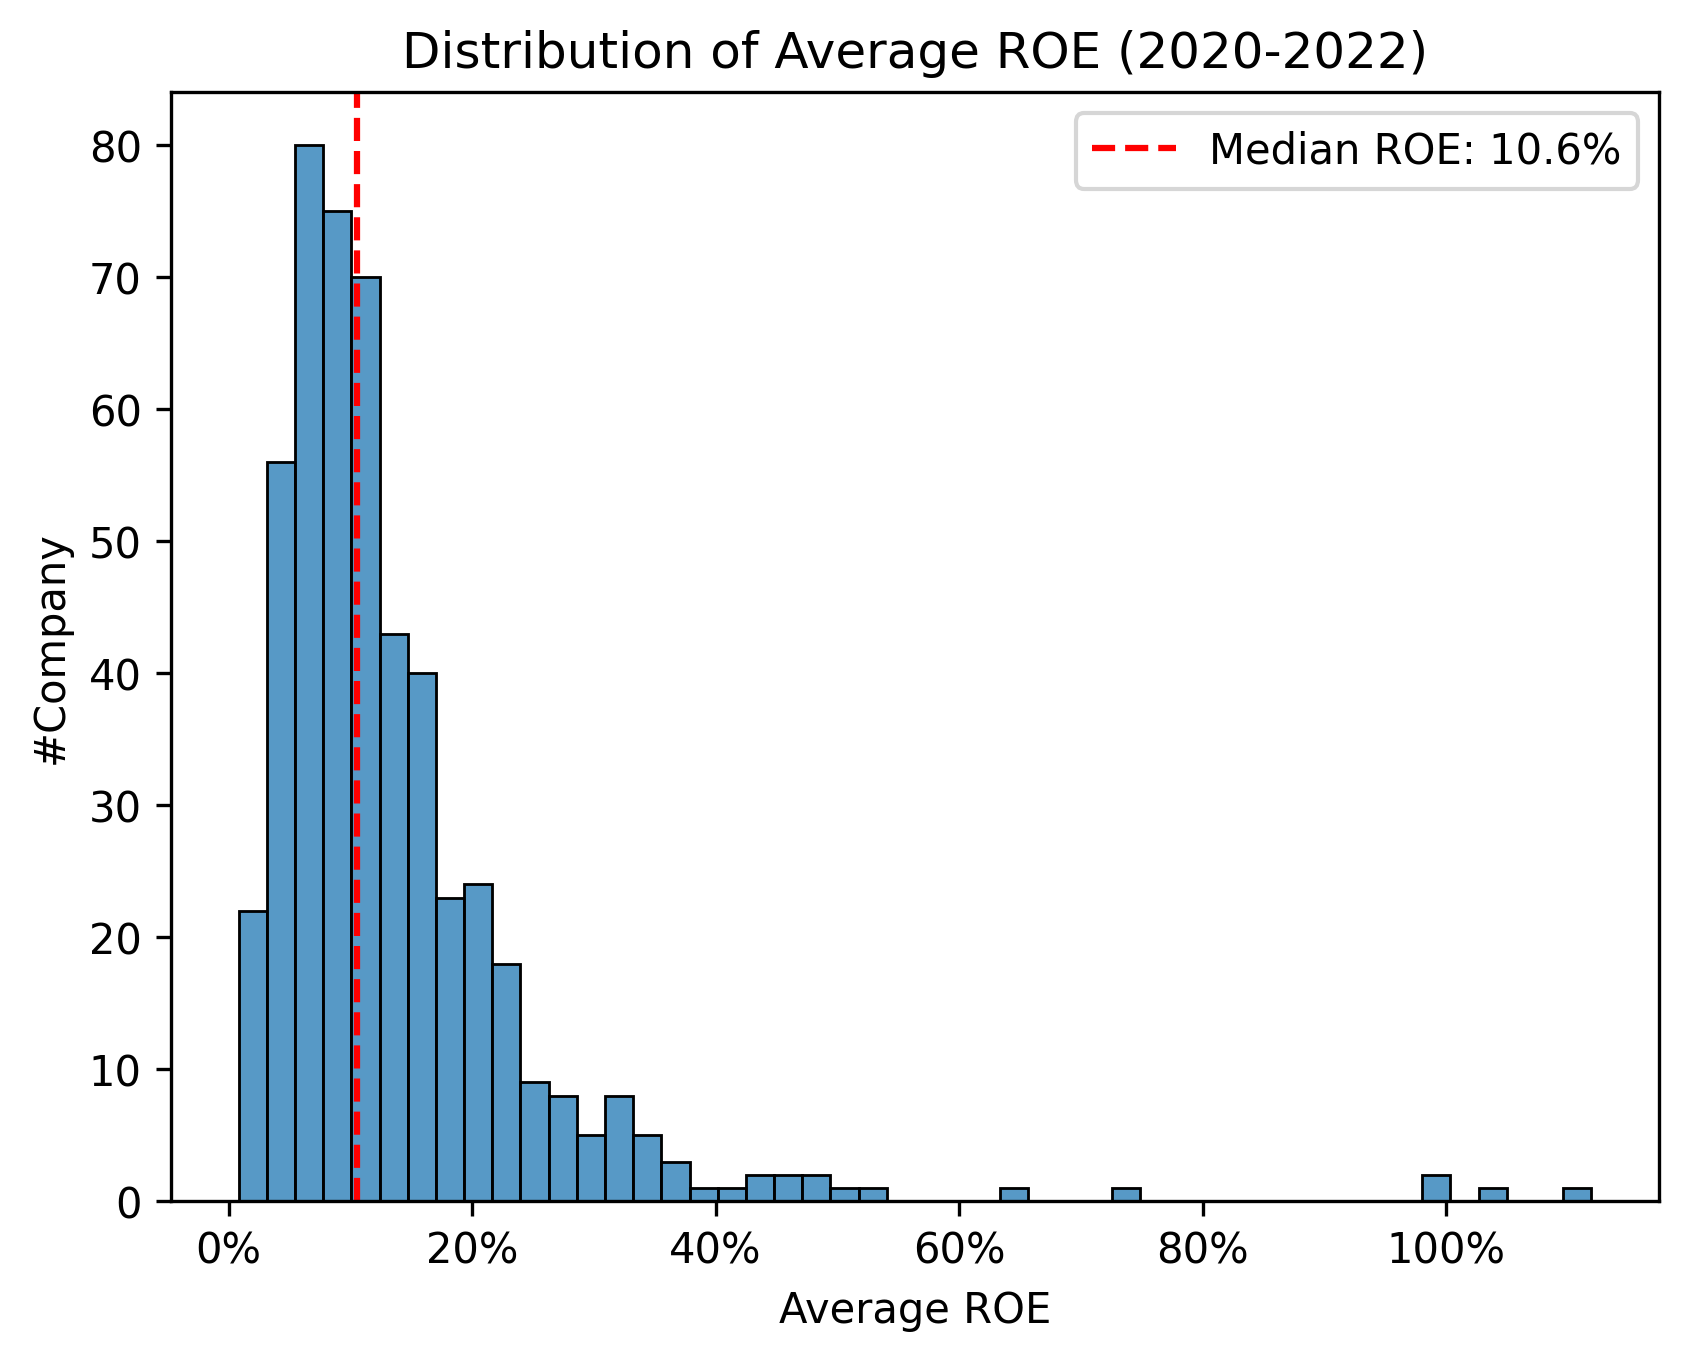

In [6]:
#condition for ROE
roe = get_roe(2020,2022) #using data from 2022 to 2024
roe.dropna(inplace=True) #drop na values
roe = roe[(roe[['2020-12-31', '2021-12-31', '2022-12-31']] > 0).all(axis=1)] #all value must greater than 0
roe['avg_roe_3year'] = roe[['2020-12-31', '2021-12-31', '2022-12-31']].mean(axis=1) #get average ROE of 3 years

#plot data
sns.histplot(x='avg_roe_3year', data=roe)
median_roe = roe['avg_roe_3year'].median()
plt.axvline(median_roe, color='red', linestyle='--', label=f'Median ROE: {median_roe*100:.1f}%') #add median line
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
plt.title('Distribution of Average ROE (2020-2022)')
plt.xlabel('Average ROE')
plt.ylabel('#Company')
plt.legend()

# Save the figure
roe_plot = plt.gcf()  # get the current figure
;

''

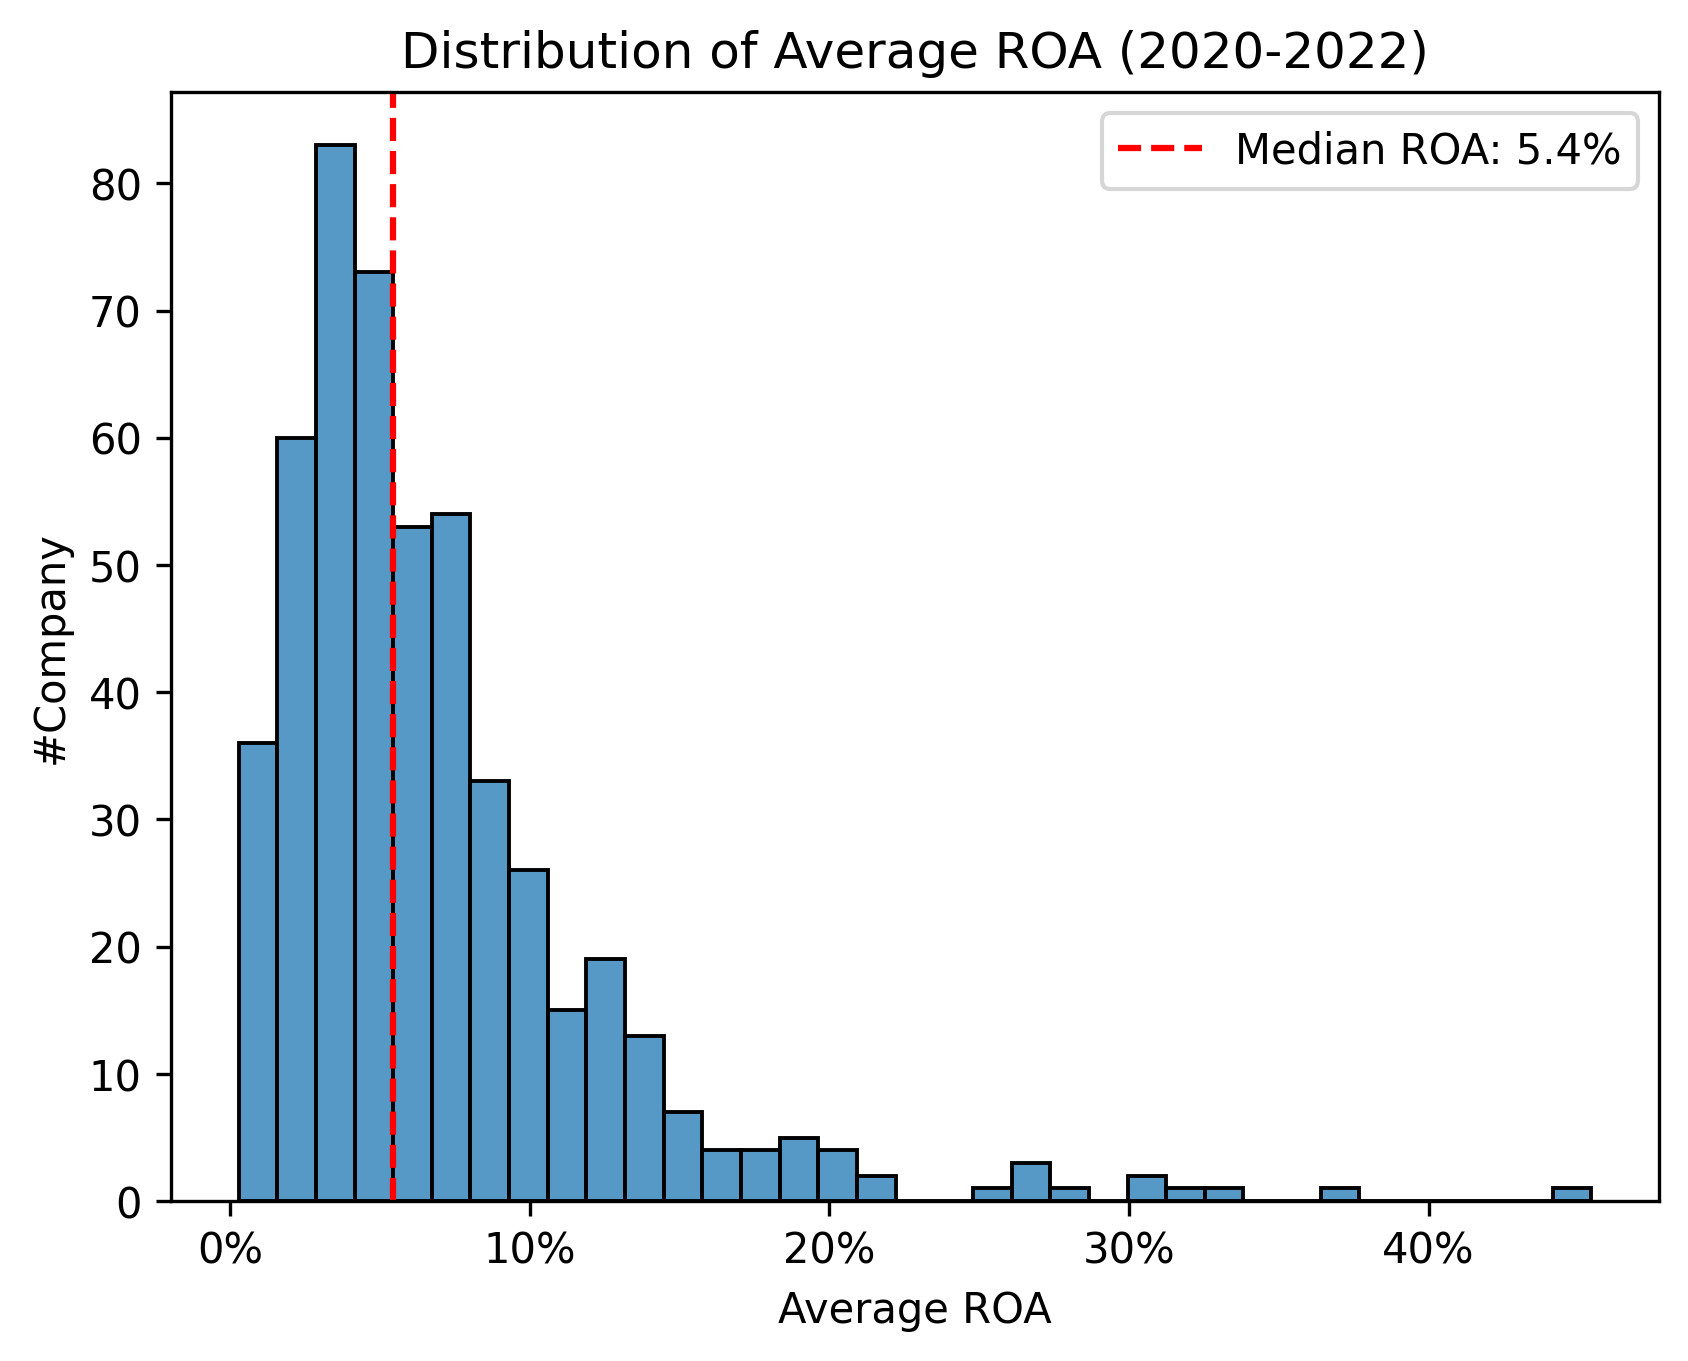

In [7]:
#condition for ROA
roa = get_roa(2020,2022) #using data from 2020 to 2022
roa.dropna(inplace=True) #drop na values
roa = roa[(roa[['2020-12-31', '2021-12-31', '2022-12-31']] > 0).all(axis=1)] #all value must greater than 0
roa['avg_roa_3year'] = roa[['2020-12-31', '2021-12-31', '2022-12-31']].mean(axis=1) #get average 3 year
roa = roa[roa['symbol'].isin(set(roe['symbol']))] #filter only symbol contains in roe table

#plot data
sns.histplot(x='avg_roa_3year', data=roa)
median_roa = roa['avg_roa_3year'].median()
plt.axvline(median_roa, color='red', linestyle='--', label=f'Median ROA: {median_roa*100:.1f}%') #add median line
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
plt.title('Distribution of Average ROA (2020-2022)')
plt.xlabel('Average ROA')
plt.ylabel('#Company')
plt.legend()
plt.legend()

# Save the figure
roa_plot = plt.gcf()  # get the current figure
;

''

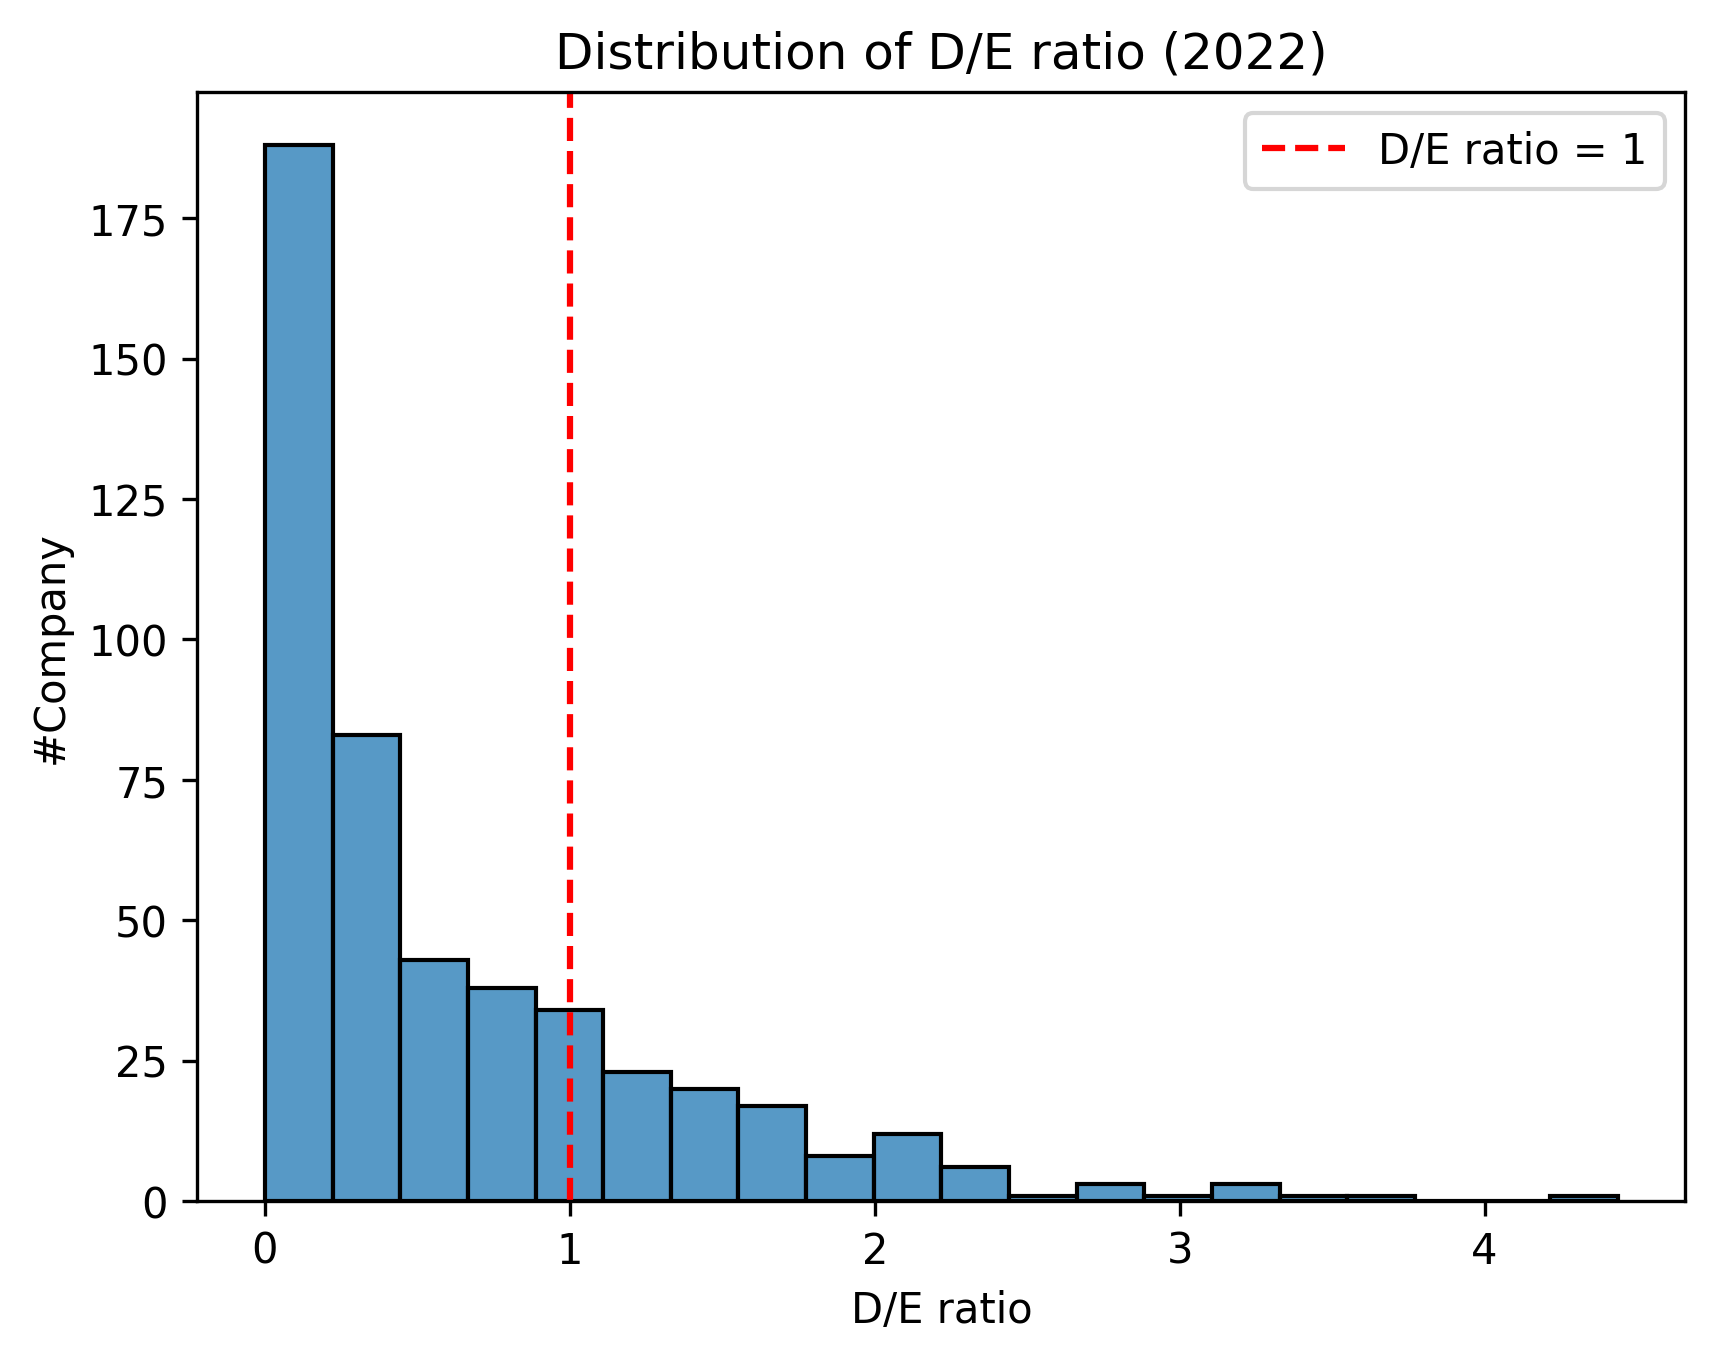

In [8]:
#condition for DE
de = get_de(2022) #using data only 2022
de.dropna(inplace=True) #drop na values
de = de[(de[['2022-12-31']] <= 5).all(axis=1) & (de[['2022-12-31']] > 0).all(axis=1)] #filter outlier
de = de[de['symbol'].isin(set(roe['symbol']))] #filter only symbol contains in roe table

#plot data
sns.histplot(x='2022-12-31', data=de)
plt.axvline(1, color='red', linestyle='--', label=f'D/E ratio = 1') #add de line = 1
plt.title('Distribution of D/E ratio (2022)')
plt.xlabel('D/E ratio')
plt.ylabel('#Company')
plt.legend()

# Save the figure
de_plot = plt.gcf()  # get the current figure
;

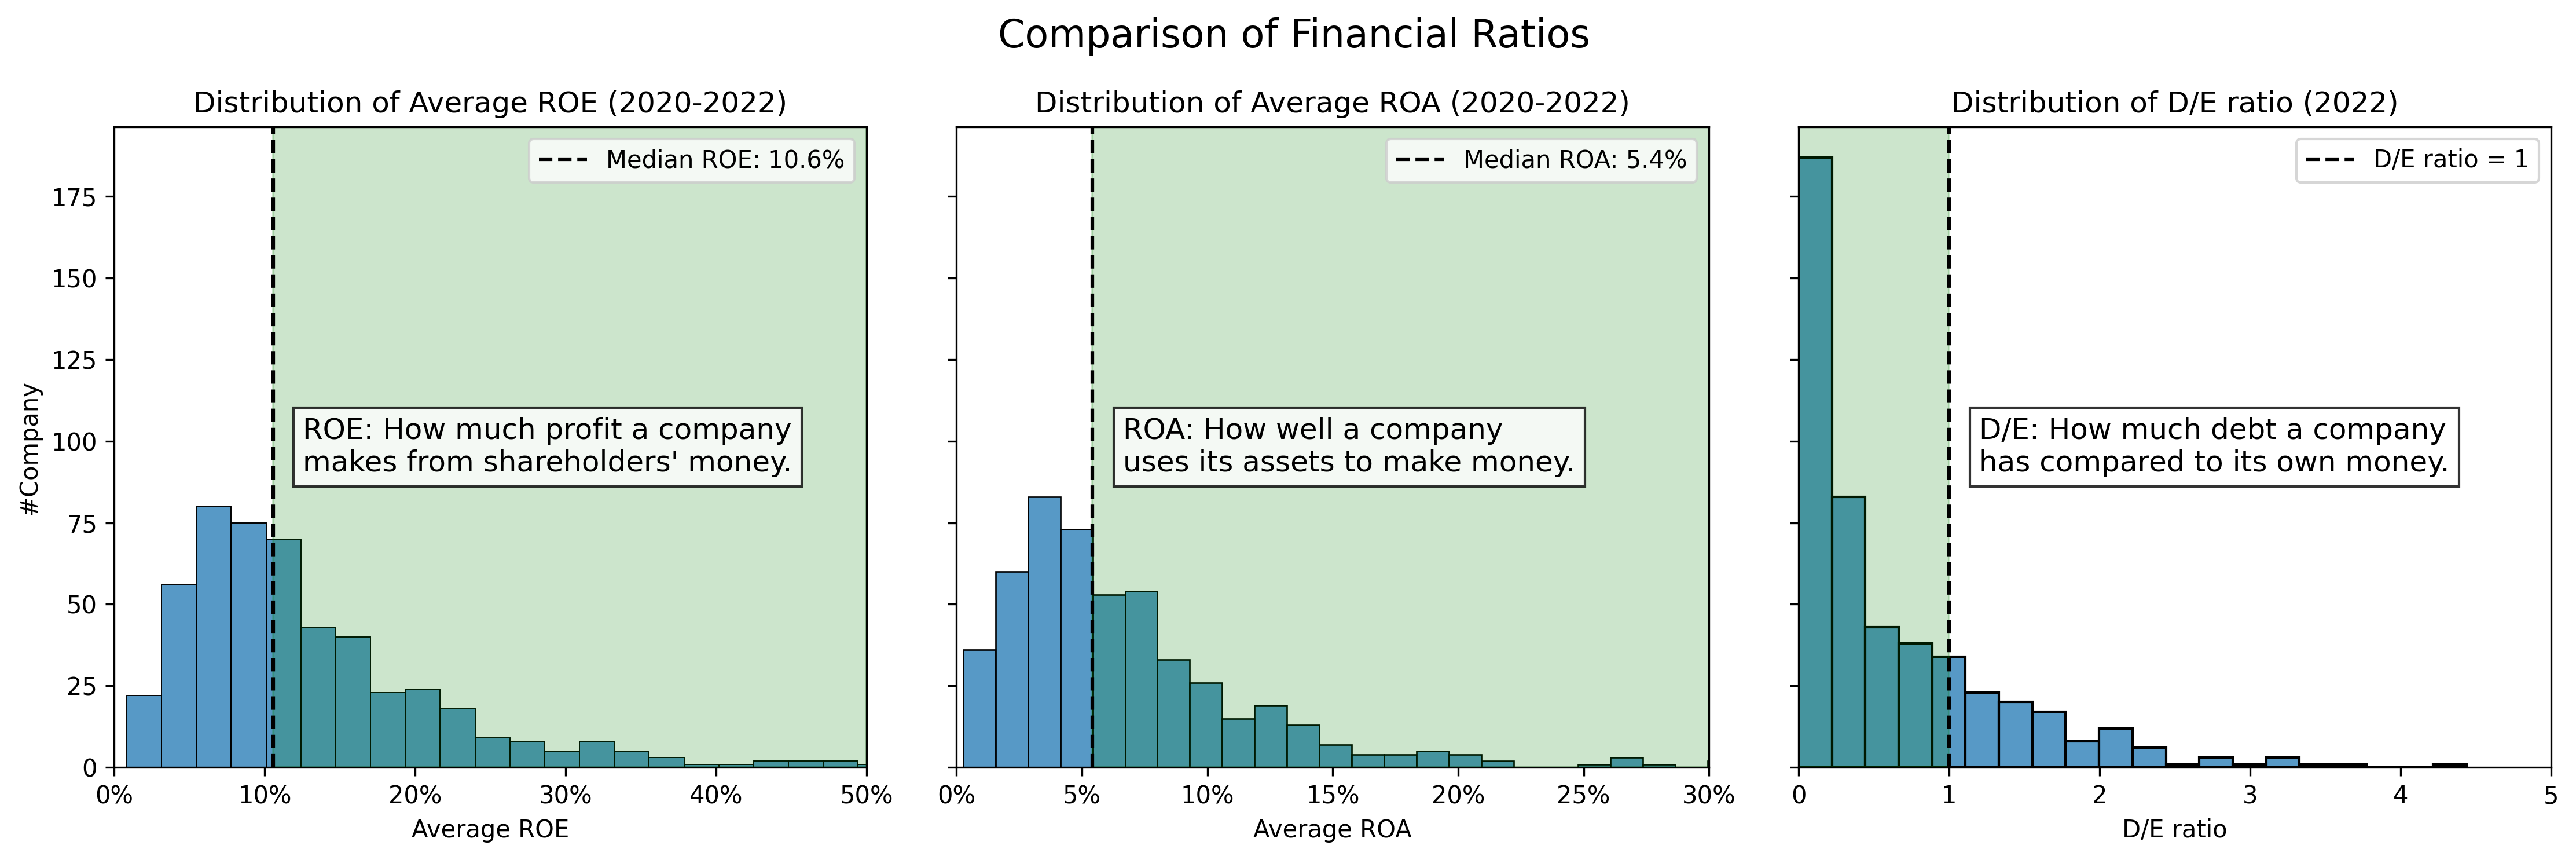

''

In [129]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

# Condition for ROE
roe = get_roe(2020,2022) #using data from 2022 to 2024
roe.dropna(inplace=True) #drop na values
roe = roe[(roe[['2020-12-31', '2021-12-31', '2022-12-31']] > 0).all(axis=1)] #all value must greater than 0
roe['avg_roe_3year'] = roe[['2020-12-31', '2021-12-31', '2022-12-31']].mean(axis=1) #get average ROE of 3 years

# Plot ROE distribution on the first subplot
sns.histplot(x='avg_roe_3year', data=roe, ax=axes[0])
median_roe = roe['avg_roe_3year'].median()
axes[0].axvline(median_roe, color='black', linestyle='--', label=f'Median ROE: {median_roe*100:.1f}%')
axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
axes[0].set_title('Distribution of Average ROE (2020-2022)')
axes[0].set_xlabel('Average ROE')
axes[0].set_ylabel('#Company')
axes[0].set_xlim(0, 0.5)
axes[0].legend()

# Condition for ROA
roa = get_roa(2020,2022) #using data from 2020 to 2022
roa.dropna(inplace=True) #drop na values
roa = roa[(roa[['2020-12-31', '2021-12-31', '2022-12-31']] > 0).all(axis=1)] #all value must greater than 0
roa['avg_roa_3year'] = roa[['2020-12-31', '2021-12-31', '2022-12-31']].mean(axis=1) #get average 3 year
roa = roa[roa['symbol'].isin(set(roe['symbol']))] #filter only symbol contains in roe table

# Plot ROA distribution on the second subplot
sns.histplot(x='avg_roa_3year', data=roa, ax=axes[1])
median_roa = roa['avg_roa_3year'].median()
axes[1].axvline(median_roa, color='black', linestyle='--', label=f'Median ROA: {median_roa*100:.1f}%')
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
axes[1].set_title('Distribution of Average ROA (2020-2022)')
axes[1].set_xlabel('Average ROA')
axes[1].set_ylabel('#Company')
axes[1].set_xlim(0, 0.3)
axes[1].legend()

# Condition for DE
de = get_de(2022) #using data only 2022
de.dropna(inplace=True) #drop na values
de = de[(de[['2022-12-31']] <= 5).all(axis=1) & (de[['2022-12-31']] > 0).all(axis=1)] #filter outlier
de = de[de['symbol'].isin(set(roa['symbol']))] #filter only symbol contains in roa table

# Plot D/E ratio distribution on the third subplot
sns.histplot(x='2022-12-31', data=de, ax=axes[2])
de_line = 1
axes[2].axvline(de_line, color='black', linestyle='--', label=f'D/E ratio = 1')
axes[2].set_title('Distribution of D/E ratio (2022)')
axes[2].set_xlabel('D/E ratio')
axes[2].set_ylabel('#Company')
axes[2].set_xlim(0, 5)
axes[2].legend()

#add highlight and textbox
y_min, y_max = axes[0].get_ylim()

axes[0].set_ylim(0, y_max)
axes[0].fill_betweenx(y=[y_min, y_max], x1=median_roe, x2=axes[0].get_xlim()[1], color='green', alpha=0.2)
axes[0].text(median_roe + (axes[0].get_xlim()[1] - median_roe) * 0.05, (y_min+y_max)/2,
             'ROE: How much profit a company\nmakes from shareholders\' money.',
             color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.8),
             ha='left', va='center')

axes[1].set_ylim(0, y_max)
axes[1].fill_betweenx(y=[y_min, y_max], x1=median_roa, x2=axes[1].get_xlim()[1], color='green', alpha=0.2)
axes[1].text(median_roa + (axes[1].get_xlim()[1] - median_roa) * 0.05, (y_min+y_max)/2,
             'ROA: How well a company\nuses its assets to make money.',
             color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.8),
             ha='left', va='center')

axes[2].set_ylim(0, y_max)
axes[2].fill_betweenx(y=[y_min, y_max], x1=axes[2].get_xlim()[0], x2=de_line, color='green', alpha=0.2)
axes[2].text(de_line + (axes[2].get_xlim()[1] - de_line) * 0.05, (y_min+y_max)/2,
             'D/E: How much debt a company\nhas compared to its own money.',
             color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.8),
             ha='left', va='center')

# Adjust the layout and display the plot
plt.suptitle('Comparison of Financial Ratios', fontsize=16)
plt.tight_layout()
plt.show()
;

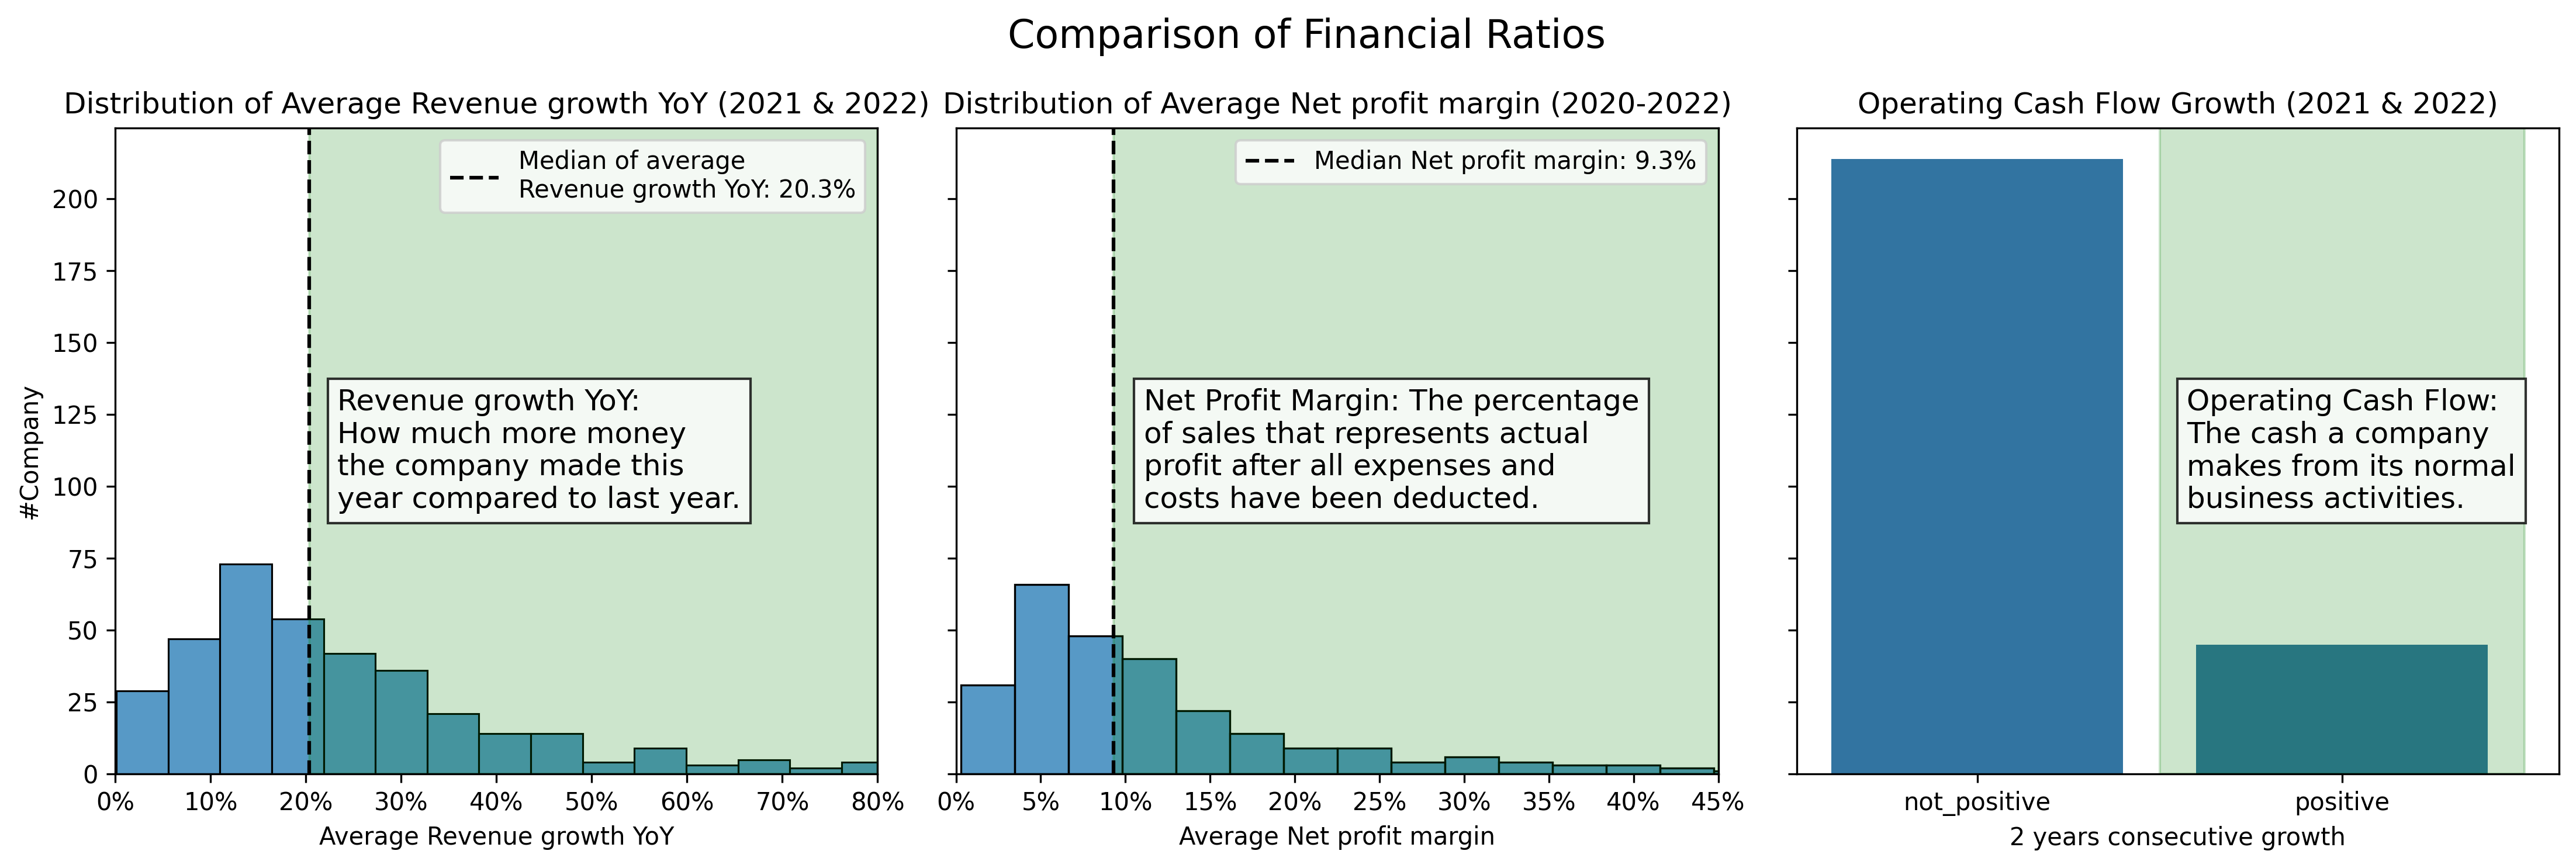

In [179]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

# Condition for revenue growth
rev_gth = get_revenue_growth_yoy(2020,2022)
rev_gth.dropna(inplace=True) #drop na values
rev_gth = rev_gth[(rev_gth[['2021-12-31', '2022-12-31']] > 0).all(axis=1) & (rev_gth[['2021-12-31', '2022-12-31']] < 2).all(axis=1)] #filter value more than 0 but less than 2
rev_gth['rev_gth_2year'] = rev_gth[['2021-12-31', '2022-12-31']].mean(axis=1) #get average 2 year

# Plot revenue growth distribution on the first subplot
sns.histplot(x='rev_gth_2year', data=rev_gth, ax=axes[0])
median_gth = rev_gth['rev_gth_2year'].median()
axes[0].axvline(median_gth, color='black', linestyle='--', label=f'Median of average\nRevenue growth YoY: {median_gth*100:.1f}%')
axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
axes[0].set_title('Distribution of Average Revenue growth YoY (2021 & 2022)')
axes[0].set_xlabel('Average Revenue growth YoY')
axes[0].set_ylabel('#Company')
axes[0].set_xlim(0, 0.8)
axes[0].legend()

# Condition for NPM
npm = get_net_profit_margin(2020,2022)
npm.dropna(inplace=True) #drop na values
npm = npm[(npm[['2020-12-31', '2021-12-31', '2022-12-31']] > 0).all(axis=1)] #all value must greater than 0
npm['avg_npm_3year'] = npm[['2020-12-31', '2021-12-31', '2022-12-31']].mean(axis=1) #get average 3 year
npm = npm[npm['symbol'].isin(set(rev_gth['symbol']))] #filter only symbol contains in rev_gth table

# Plot NPM distribution on the second subplot
sns.histplot(x='avg_npm_3year', data=npm, ax=axes[1])
median_npm = npm['avg_npm_3year'].median()
axes[1].axvline(median_npm, color='black', linestyle='--', label=f'Median Net profit margin: {median_npm*100:.1f}%')
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
axes[1].set_title('Distribution of Average Net profit margin (2020-2022)')
axes[1].set_xlabel('Average Net profit margin')
axes[1].set_ylabel('#Company')
axes[1].set_xlim(0, 0.45)
axes[1].legend()

# Condition for operating cashflow
oper = get_operating_cashflow_growth(2020,2022)
oper.dropna(inplace=True) #drop na values
oper['2 years consecutive growth'] = ((oper['2021-12-31'] > 0) & (oper['2022-12-31'] > 0)).apply(lambda x: 'positive' if x else 'not_positive')
oper = oper[oper['symbol'].isin(set(npm['symbol']))] #filter only symbol contains in npm table

# Plot operating cashflow distribution on the third subplot
sns.countplot(x='2 years consecutive growth', data=oper, ax=axes[2], order=['not_positive', 'positive'])
axes[2].set_title('Distribution of Operating Cash Flow Growth')
axes[2].set_xlabel('2 years consecutive growth')
axes[2].set_ylabel('#Company')
axes[2].set_title('Operating Cash Flow Growth (2021 & 2022)')

#add highlight and textbox
y_min, y_max = axes[0].get_ylim()

axes[0].set_ylim(0, y_max)
axes[0].fill_betweenx(y=[y_min, y_max], x1=median_gth, x2=axes[0].get_xlim()[1], color='green', alpha=0.2)
axes[0].text(median_gth + (axes[0].get_xlim()[1] - median_gth) * 0.05, (y_min+y_max)/2,
             'Revenue growth YoY:\nHow much more money\nthe company made this\nyear compared to last year.',
             color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.8),
             ha='left', va='center')

axes[1].set_ylim(0, y_max)
axes[1].fill_betweenx(y=[y_min, y_max], x1=median_npm, x2=axes[1].get_xlim()[1], color='green', alpha=0.2)
axes[1].text(median_npm + (axes[1].get_xlim()[1] - median_npm) * 0.05, (y_min+y_max)/2,
             'Net Profit Margin: The percentage\nof sales that represents actual \nprofit after all expenses and\ncosts have been deducted.',
             color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.8),
             ha='left', va='center')

# Highlight the area for the positive category
x_pos = axes[2].get_xticks()
axes[2].axvspan(x_pos[1] - 0.5, x_pos[1] + 0.5, color='green', alpha=0.2)
axes[2].text(0.5 + (axes[2].get_xlim()[1] - median_npm) * 0.05, (y_min+y_max)/2,
             'Operating Cash Flow:\nThe cash a company\nmakes from its normal\nbusiness activities.',
             color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.8),
             ha='left', va='center')

# Adjust the layout and display the plot
plt.suptitle('Comparison of Financial Ratios', fontsize=16)
plt.tight_layout()
plt.show()

In [170]:
x_pos

[0, 1]